Source Code:
https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb#scrollTo=vphaFabJPPKo

In [ ]:
%pip install -q diffusers

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import numpy as np
from itertools import chain
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# from torchmetrics.image import StructuralSimilarityIndexMeasure

### The numpy version of dataset (Keras) I used for SSIM measure

In [ ]:
# from keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# x_train = np.expand_dims(x_train, 1)

In [ ]:
# x_train_torch = torch.from_numpy(x_train[0:3300])

### The torch version of dataset

In [ ]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

In [ ]:
print(len(dataset.targets))

60000


### Training phase

In [ ]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount

In [ ]:
# Dataloader (you can mess with batch size)
batch_size = 64
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 10 # 10 is good, I sat it to 20 (takes alot of time)

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images, previously it was 1
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

  for x, y in train_dataloader:

    # Get some data and prepare the corrupted version
    x = x.to(device) # Data on the GPU
    noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
    noisy_x = corrupt(x, noise_amount) # Create our noisy x
    # print(noisy_x.shape)
    # print(x.shape)
    # Get the model prediction
    pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

    # Calculate the loss
    loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

    # Backprop and update the params:
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Store the loss for later
    losses.append(loss.item())

  # Print our the average of the loss values for this epoch:
  avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
  print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

Finished epoch 0. Average loss for this epoch: 0.016826
Finished epoch 1. Average loss for this epoch: 0.012227
Finished epoch 2. Average loss for this epoch: 0.011260
Finished epoch 3. Average loss for this epoch: 0.010794
Finished epoch 4. Average loss for this epoch: 0.010410
Finished epoch 5. Average loss for this epoch: 0.010363
Finished epoch 6. Average loss for this epoch: 0.010185
Finished epoch 7. Average loss for this epoch: 0.009957
Finished epoch 8. Average loss for this epoch: 0.009822
Finished epoch 9. Average loss for this epoch: 0.009771


### Sampling phase

In [ ]:
n_steps = 100
x = torch.rand(3300, 1, 28, 28).to(device) # 3300 is the number of samples generated
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

if type(x) is torch.Tensor:
      x = x.detach().cpu().numpy()

In [ ]:
# del x
gc.collect()

0

In [ ]:
print(x.shape)
print(type(x))

(3300, 1, 28, 28)
<class 'numpy.ndarray'>


In [ ]:
# x = torch.squeeze(x)
# print(x.shape)
# ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
# ssim(x_train_torch, x)

torch.Size([3300, 28, 28])


### FID score (new version)

In [ ]:
gen_images = np.array([])
length = len(x[0][0])

In [ ]:
print(type(x))
print(x.shape)

<class 'numpy.ndarray'>
(3300, 1, 28, 28)


In [ ]:
for i in range(len(x)):
  for j in range(len(x[0])):
    reshaped = x[i][j].reshape(1, length, length, 1)
    # print(reshaped.shape)
    if len(gen_images)==0:
      gen_images = reshaped
    else:
      gen_images = np.append(gen_images, reshaped, axis = 0)
    # print(gen_images.shape)

In [ ]:
gc.collect()

0

In [ ]:
print(gen_images.shape)

(3300, 28, 28, 1)


In [ ]:
train_set = dataset.data.numpy()
train_set = train_set.reshape(len(train_set), 28, 28, 1)
print(train_set.shape)

(60000, 28, 28, 1)


In [ ]:
train_labels = dataset.targets.data.numpy()

In [ ]:
# label_counts = np.bincount(train_labels)
# print("Label distribution in training set:", label_counts)

Label distribution in training set: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


In [ ]:
# min_samples = 1000
# num_labels = 10
# sampled_indices = []
# for label in range(num_labels):
#     label_indices = np.where(train_labels == label)[0]
#     sampled_indices.extend(np.random.choice(label_indices, size=min_samples, replace=False))

# sampled_indices = np.array(sampled_indices)
# sampled_images = train_set[sampled_indices]
# sampled_labels = train_labels[sampled_indices]

In [ ]:
# shuffle_indices = np.random.permutation(len(sampled_labels))
# sampled_images = sampled_images[shuffle_indices]
# # sampled_labels = sampled_labels[shuffle_indices]

In [ ]:
# sampled_labels = sampled_labels[shuffle_indices]

In [ ]:
# from numpy import trace, iscomplexobj, cov, asarray
# from numpy.random import randint
# from scipy.linalg import sqrtm
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
# from keras.datasets.mnist import load_data
# from skimage.transform import resize

In [ ]:
# def calculate_fid(model, images1, images2):
#  # calculate activations
#  act1 = model.predict(images1)
#  act2 = model.predict(images2)
#  # calculate mean and covariance statistics
#  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
#  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
#  # calculate sum squared difference between means
#  ssdiff = np.sum((mu1 - mu2)**2.0)
#  # calculate sqrt of product between cov
#  covmean = sqrtm(sigma1.dot(sigma2))
#  # check and correct imaginary numbers from sqrt
#  if iscomplexobj(covmean):
#   covmean = covmean.real
#  # calculate score
#  fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
#  return fid

In [ ]:
# def scale_images(images, new_shape):
#  images_list = list()
#  for image in images:
#     # resize with nearest neighbor interpolation
#     new_image = resize(image, new_shape, 0)
#     # store
#     images_list.append(new_image)
#  return asarray(images_list)

In [ ]:
# model_1 = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [ ]:
# images1 = gen_images.astype('float32')
# images2 = sampled_images.astype('float32')

In [ ]:
# print(type(images2))
# print(images2.shape)

<class 'numpy.ndarray'>
(10000, 28, 28, 1)


In [ ]:
# images1 = scale_images(images1, (299,299,3))
# images2 = scale_images(images2, (299,299,3))

In [ ]:
# print('Scaled', images1.shape, images2.shape)

Scaled (3300, 299, 299, 3) (10000, 299, 299, 3)


In [ ]:
# images1 = preprocess_input(images1)
# images2 = preprocess_input(images2)

In [ ]:
# gc.collect()

3363

In [ ]:
# from tensorflow.keras.utils import Sequence

# class DataGenerator(Sequence):
#     def __init__(self, x_set, batch_size):
#         self.x = x_set
#         self.batch_size = batch_size

#     def __len__(self):
#         return int(np.ceil(len(self.x) / float(self.batch_size)))

#     def __getitem__(self, idx):
#         batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
#         return batch_x

# train_gen = DataGenerator(images1, 32)
# test_gen = DataGenerator(images2, 32)

In [ ]:
fid = calculate_fid(model_1, train_gen, test_gen)
print('FID: %.3f' % fid)

313/313 [==============================] - 15s 48ms/step
FID (different): 351.252


### FID score (old version)

In [ ]:
def calc_mu_and_sigma(dataset):
  # The returned sigma is the covariance matrix and mu is the mean
  flatten_images = []

  for i in range(len(dataset)):
    vectorize = np.array(list(chain.from_iterable(dataset[i])))
    flatten_images.append(vectorize)

  flatten_images = np.array(flatten_images)
  print("Flatten images: ", flatten_images.shape)
  mu = flatten_images.mean(axis = 0)
  print("Mu: ", mu.shape)
  sigma = np.dot(flatten_images[0], flatten_images[0].T)

  print("Sigma: ", sigma.shape)

  for i in range(1, len(flatten_images)):
    Ui = np.dot(flatten_images[i], flatten_images[i].T)
    sigma += Ui

  mu_mu_T = np.dot(mu, mu.T)
  sigma = sigma / len(dataset)
  sigma = sigma - mu_mu_T

  return mu, sigma, flatten_images

In [ ]:
mu_train, sigma_train, vectorized_train = calc_mu_and_sigma(train_set)

Flatten images:  (60000, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
mu_gen, sigma_gen, vectorized_test = calc_mu_and_sigma(gen_images)

Flatten images:  (3300, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
## previous result was 18905.1592
from scipy.linalg import sqrtm

diff_mean = np.sum(np.square(mu_train - mu_gen))

dot_of_sigmas = np.dot(sigma_train, sigma_gen.T)

diff_cov = sigma_train + sigma_gen - 2*sqrtm(dot_of_sigmas)

print("FID score of DDPM with ", n_epochs, " epochs and ", batch_size, " batch size:\n", round(np.absolute(diff_mean + np.trace(diff_cov)), 4))

FID score of DDPM with  10  epochs and  128  batch size:
 14667.935


### Plotting generated images

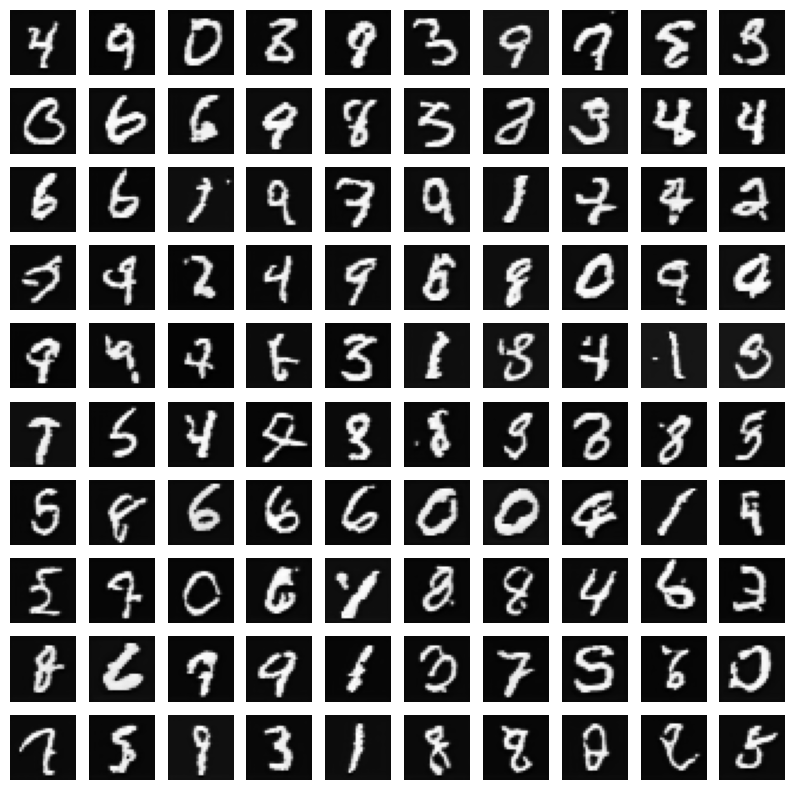

In [ ]:
fig = plt.figure(figsize=(10, 10))
idx = 0
for r in range(10):
    for c in range(10):
        fig.add_subplot(10, 10, idx + 1)
        if idx < len(x):
            plt.imshow(x[idx][0], cmap="gray")
            plt.axis("off")
            # if save:
            #   image_name = path_to_save + '/'+str(epoch)+"_"+str(batch_size)+"_label_"+str(idx)+"_"+ str(index) +".png"
            #   plt.savefig(image_name)
            idx += 1
plt.show()
plt.close(fig)

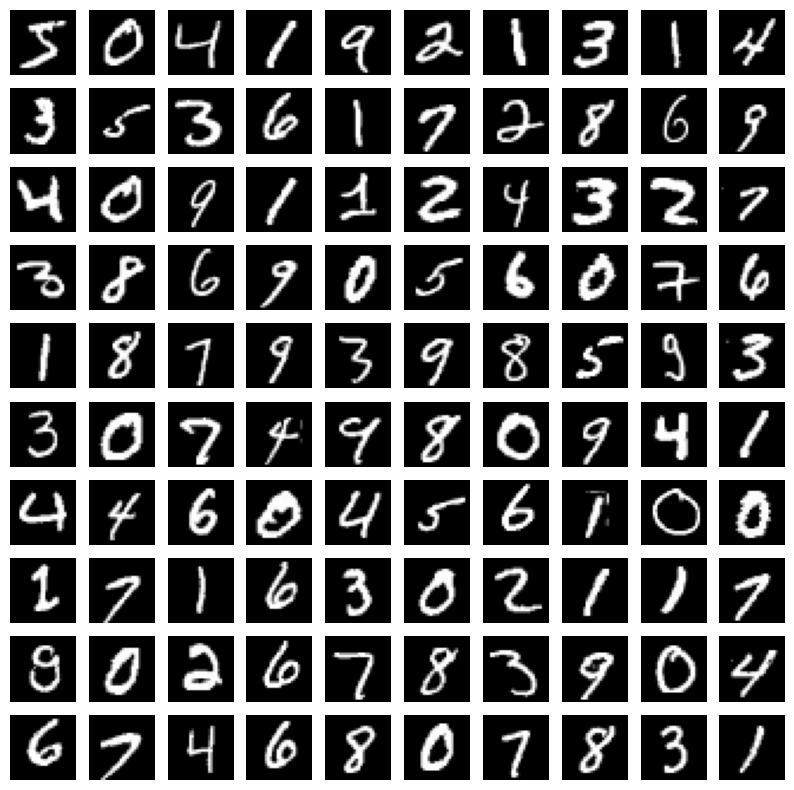

In [ ]:
fig = plt.figure(figsize=(10, 10))
idx = 0
for r in range(10):
    for c in range(10):
        fig.add_subplot(10, 10, idx + 1)
        if idx < len(x):
            plt.imshow(train_set[idx], cmap="gray")
            plt.axis("off")
            idx += 1
plt.show()
plt.close(fig)

### Diversity Measure

In [ ]:
def scatter(first_axis, second_axis, title):
  plt.figure(figsize=(10, 8))
  plt.title(title)
  plt.scatter(first_axis, second_axis, marker = '.')

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def map_diversity(data, variance_PCA):
  if data.ndim == 3:
    data = data.squeeze()
  pca = PCA(n_components = variance_PCA)
  reduced_vectors_pca = pca.fit_transform(data)
  # print(pca.n_components_) # If interested
  tsne = TSNE(n_components=2)
  reduced_vectors_tsne = tsne.fit_transform(reduced_vectors_pca)
  return reduced_vectors_tsne

In [ ]:
reduced_dimension = map_diversity(data = vectorized_test, variance_PCA = 0.85)

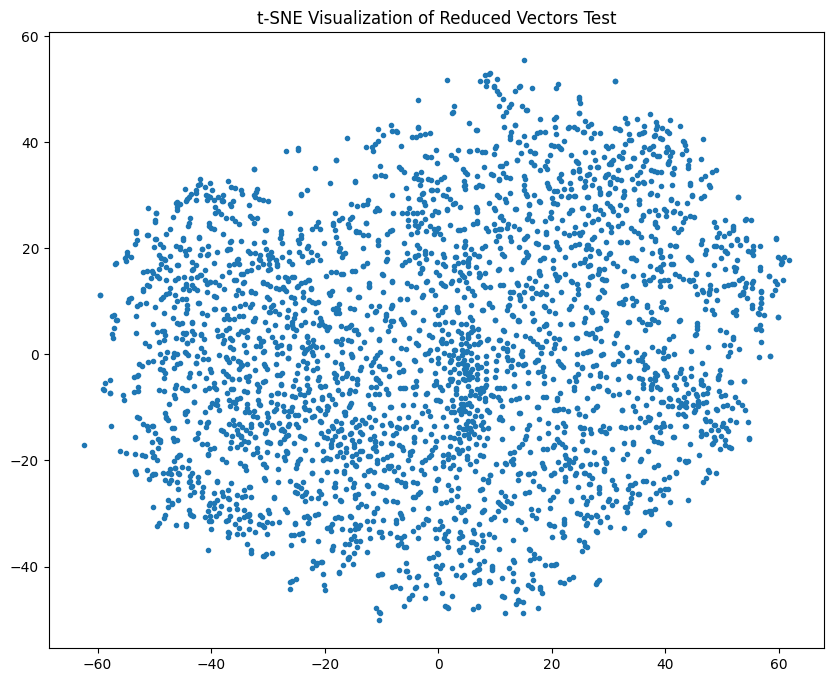

In [ ]:
scatter(reduced_dimension[:, 0], reduced_dimension[:, 1], 't-SNE Visualization of Reduced Vectors Test')

In [ ]:
reduced_dimension = map_diversity(data = vectorized_train, variance_PCA = 0.85)

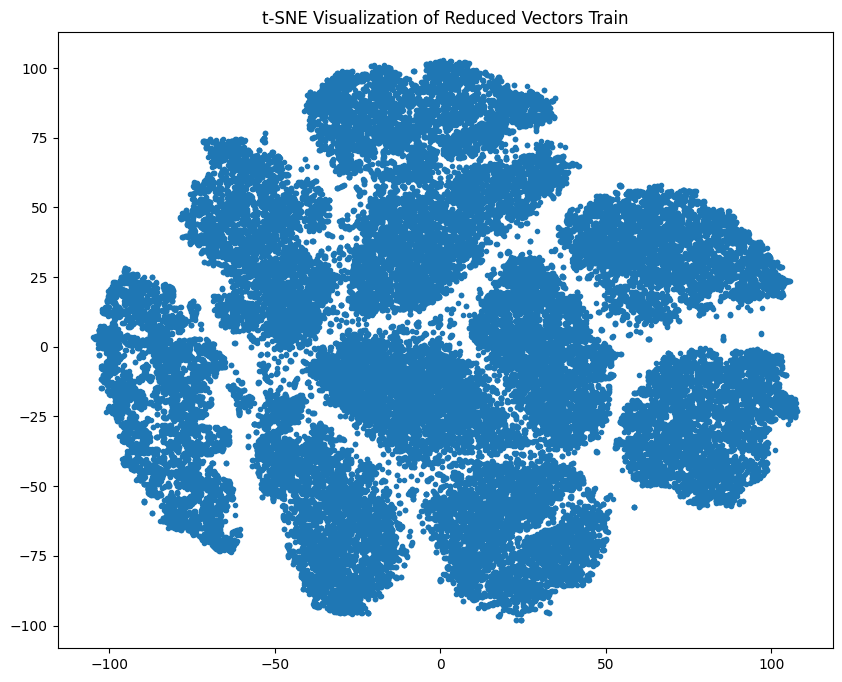

In [ ]:
scatter(reduced_dimension[:, 0], reduced_dimension[:, 1], 't-SNE Visualization of Reduced Vectors Train')